# Self-Driving Car Engineer Nanodegree


## Project2: ** Advanced Lane Finding** 

** Solution by luk6xff (May 2019)
** Writeup here: [P2 writeup](WRITEUP.md)

### In this project, a goal is to write a software pipeline to identify the lane boundaries in a video.

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
# Importing some useful packages used in the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## 1. Camera calibration and distortion coefficients 

Camera intrinsic matrix:
[[  1.15777942e+03   0.00000000e+00   6.67111049e+02]
 [  0.00000000e+00   1.15282305e+03   3.86129069e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Camera distortion coefficients:
[[-0.24688833 -0.02372814 -0.00109843  0.00035105 -0.00259138]]


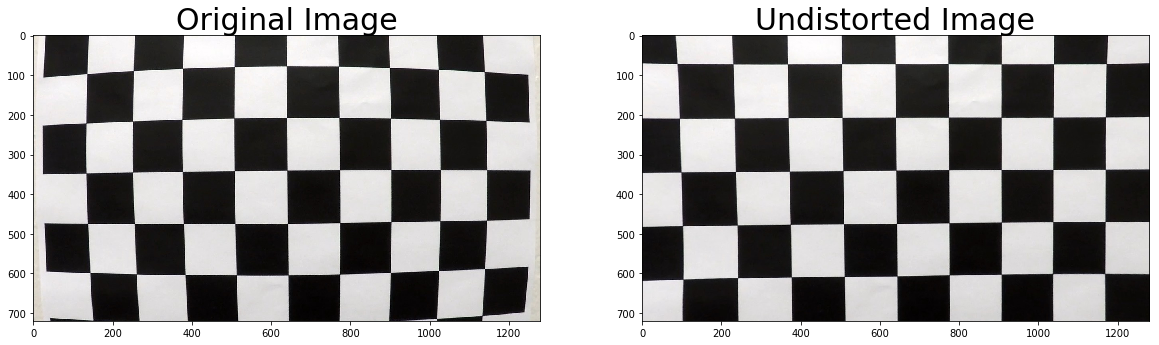

In [2]:
def calibrate_camera(images, nx, ny, img_size):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    #print(objp[:,:2])
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), cv2.CALIB_CB_ADAPTIVE_THRESH)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save the images
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cols = 8
            #rows = 1
            #plt.figure(figsize=(50,70))
            #plt.subplot(cols, rows, (idx%8)+1)
            #plt.imshow(img)
    # Do camera calibration given object points and image points
    ret, cam_mtx, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cam_mtx, dist_coeffs



def undistort_image(img, cam_mtx, dist_coeffs):
    return cv2.undistort(img, cam_mtx, dist_coeffs, None, cam_mtx)


############### TESTS ############### 
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Based on used images (camera_cal/calibration*.jpg), I set the number of corners
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Test image
img      = cv2.imread('camera_cal/calibration1.jpg')
img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])


cam_mtx, dist_coeffs = calibrate_camera(images, nx, ny, img_size)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# cam_mtx     = [fx  0  cx]
#               [0  fy  cy]
#               [0   0   1]
# dist_coeffs = [k1, k2, p1, p2, k3]

######################## CAMERA_PICKLE ########################
# CREATE AND SAVE CAMERA PICKLE FOR LATER USAGE ###########
cam_pickle = {}
cam_pickle["cam_mtx"] = cam_mtx
cam_pickle["dist_coeffs"] = dist_coeffs
print('Camera intrinsic matrix:\n{}'.format(cam_mtx))
print('Camera distortion coefficients:\n{}'.format(dist_coeffs))
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Undistort image
undistorted_img = undistort_image(img, cam_mtx, dist_coeffs)
###### Debug save
cv2.imwrite('output_images/distorted_image.png', img)
cv2.imwrite('output_images/undistorted_image.png', undistorted_img)

# Print the calibration results - original (distorted) image, and undistorted one.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

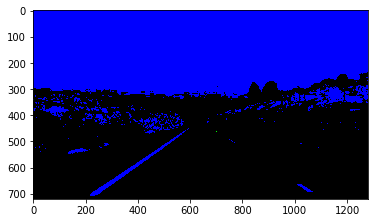

In [3]:
def apply_threshold(img, grad_thresh=(20,100), s_color_thresh=(90,255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] #Saturation channel
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find sobel gradient
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel_x  = np.absolute(sobel_x)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= grad_thresh[0]) & (scaled_sobel <= grad_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary))*255
    return color_binary

############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary_img = apply_threshold(undistorted_img, grad_thresh=(150,200), s_color_thresh=(90,255))
###### Debug save
cv2.imwrite('output_images/undistorted_threshlded_image.png', binary_img)
plt.imshow(binary_img)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view" or "top-down- view).

(1280, 720)


True

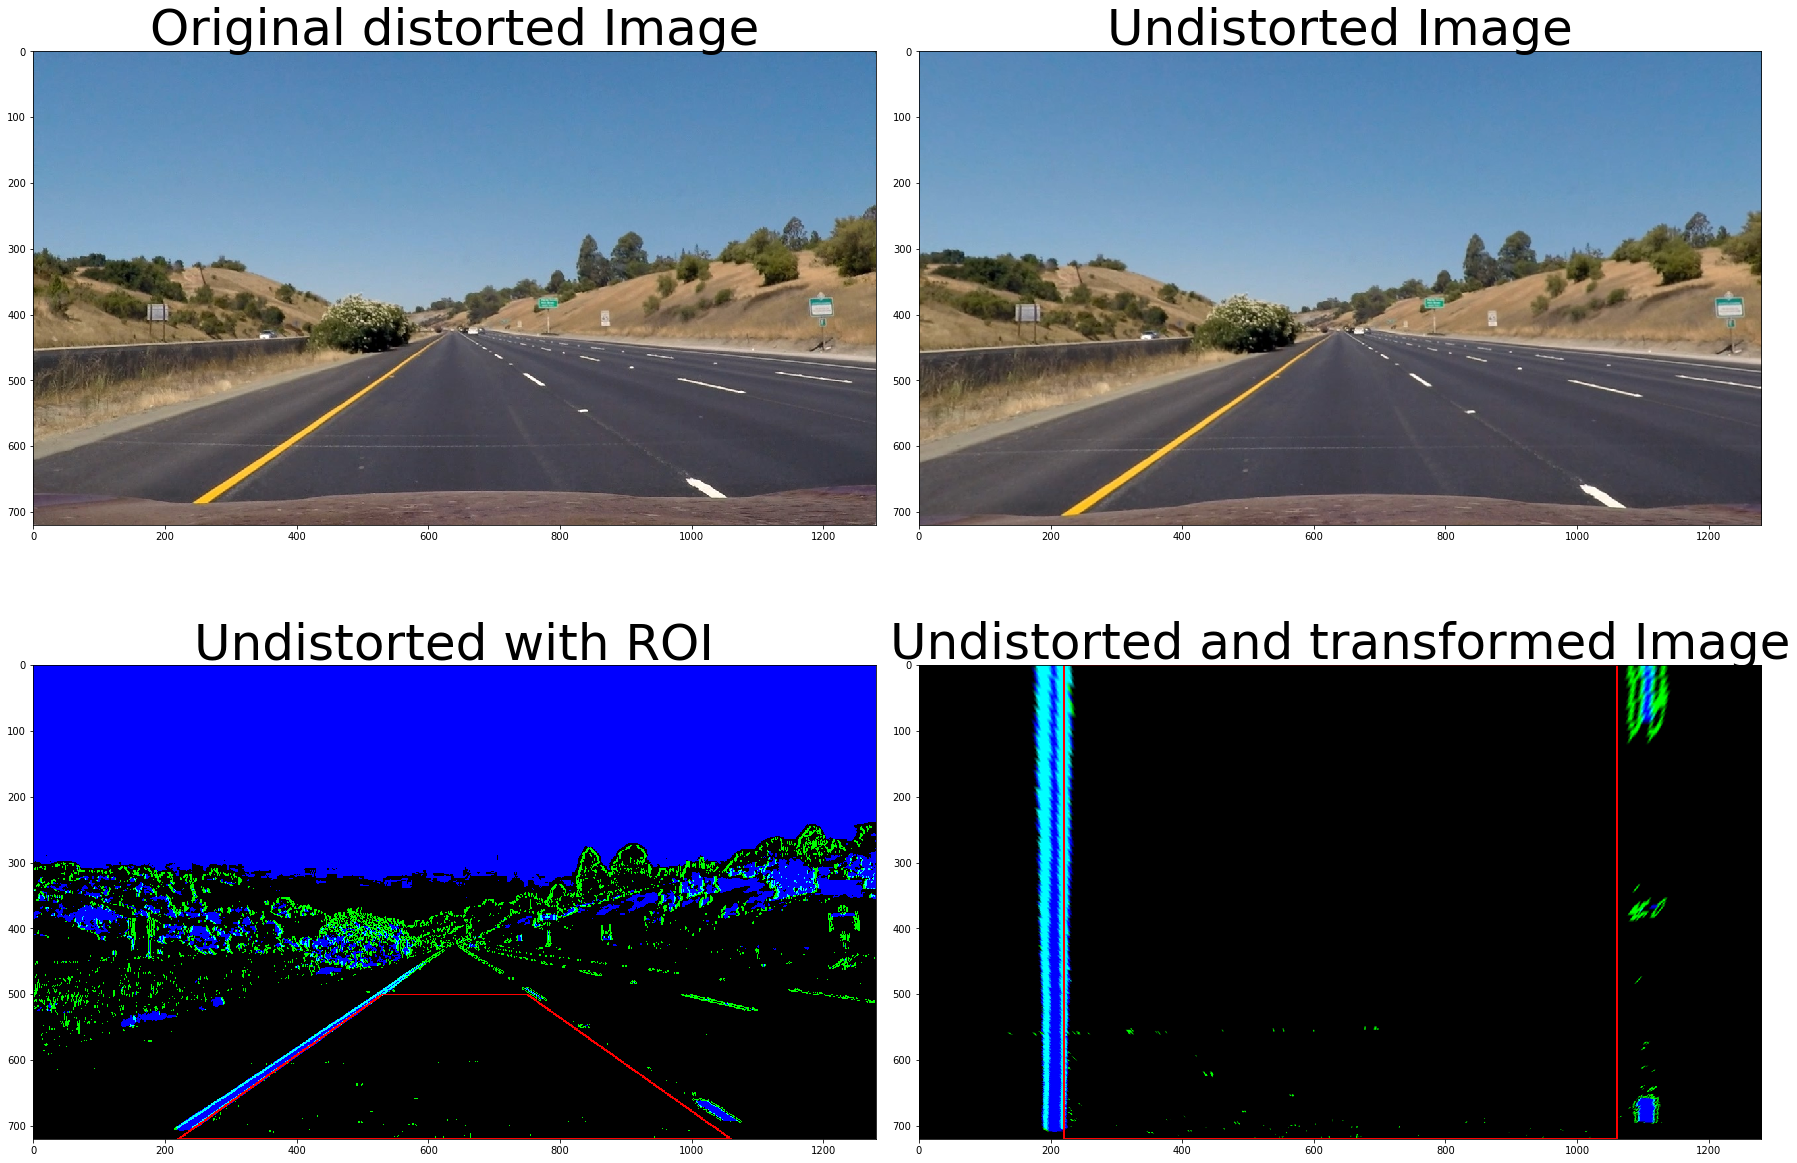

In [4]:
def top_down_view(img):
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # For source points i pick the points describing trapezoid as shown below
    # Setup: x_center=640, x_offset_top=420, x_offset_bottom=110, y_top=720, y_bottom=500
    x_center=640
    x_offset_top=420
    x_offset_bottom=110
    y_top=img_size[1]#720
    y_bottom=500
    src = np.float32([[x_center+x_offset_bottom,y_bottom],
                      [x_center+x_offset_top,y_top],
                      [x_center-x_offset_top,y_top],
                      [x_center-x_offset_bottom,y_bottom]])
    # 4 destination points dst = np.float32([[,],[,],[,],[,]])
    # For destination points I am taking the image size to map trapezoid on lines (starting from top-left corner)
    # + add small offset to get some offset in the image
    # Values have been chosen after analysing images

    dst = np.float32([[x_center+x_offset_top,0],
                      [x_center+x_offset_top,img_size[1]],
                      [x_center-x_offset_top,img_size[1]],
                      [x_center-x_offset_top,0]])
    
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Draw src and dst guide lines on both images
    img_with_roi = cv2.polylines(img, np.int32([src]), True, (255,0,0), 2)
    warped = cv2.polylines(warped, np.int32([dst]), True, (255,0,0), 2)
    
    return img_with_roi, warped, Minv


############################## TESTS ##############################
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["inv_perspective_matrix"] = inv_perspective_matrix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################

# Plots
f, (p1, p2) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
p1[0].imshow(image)
p1[0].set_title('Original distorted Image', fontsize=50)
p1[1].imshow(undistorted_img)
p1[1].set_title('Undistorted Image', fontsize=50)
p2[0].imshow(img_with_roi)
p2[0].set_title('Undistorted with ROI', fontsize=50)
p2[1].imshow(transformed_top_down_img)
p2[1].set_title('Undistorted and transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

###### Debug save
cv2.imwrite('output_images/undistorted_with_ROI.png', img_with_roi)
cv2.imwrite('output_images/undistorted_and_transformed_image.png', transformed_top_down_img)

## 4. Detect lane pixels and fit to find the lane boundary.

(1280, 720)


True

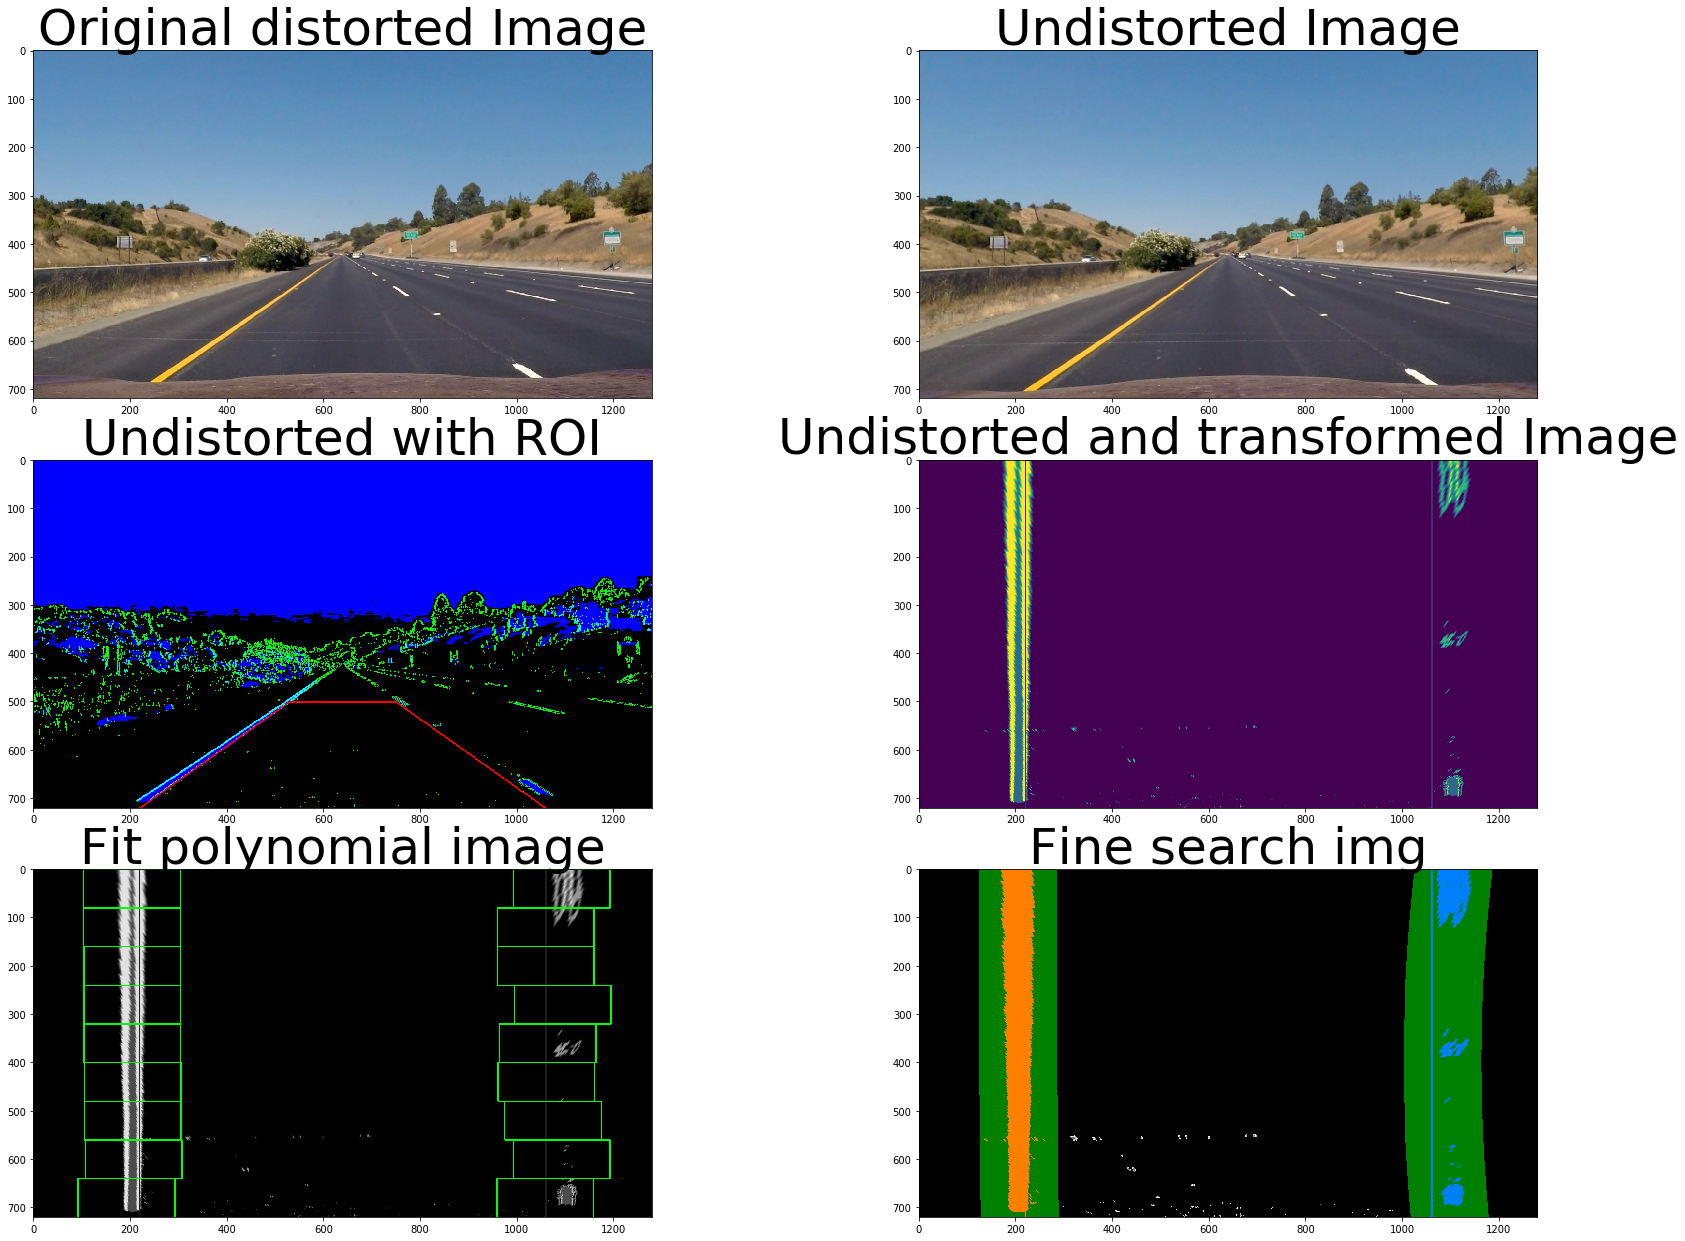

In [5]:
def find_lane_coarse(binary_warped_img):
    '''
    Find the lines with Sliding windows method
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped_img[binary_warped_img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped_img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img




def fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty):
    """
    Fits a polynomial to all relevant pixels we have found in our sliding windows 
    """
    visualize = False

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization of the polynomial ##
    if visualize:
        # Colors in the left and right lane regions
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        

    return left_fitx, right_fitx, ploty




def find_lane_fine(binary_warped_img, left_fit, right_fit):
    """
    Set the area to search for activated pixels based on margin
    With a previous set of lane fit parameters in pixel space, search in the neighbourhood 
    and return updated lane pixel vectors
    """
    # The width of the margin around the previous polynomial to search
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## Visualization ##    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Check in case if no pixels were found
    if leftx.size == 0 or rightx.size == 0:
        return False, leftx, lefty, rightx, righty, out_img

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_polynomial(binary_warped_img, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result_img = cv2.addWeighted(out_img, 1, window_img, 0.5, 0)
    
    ###### Debug save
    # Plot the polynomial lines onto the image
    #     plt.imshow(result_img)
    #     plt.plot(left_fitx, ploty, color='yellow')
    #     plt.plot(right_fitx, ploty, color='yellow')
    #     plt.savefig('output_images/polynomial_line.png')
    ## End visualization steps ##
    
    return True, leftx, lefty, rightx, righty, result_img



############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Plots
f, (p0, p1, p2) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
p0[0].imshow(image)
p0[0].set_title('Original distorted Image', fontsize=50)
p0[1].imshow(undistorted_img)
p0[1].set_title('Undistorted Image', fontsize=50)
p1[0].imshow(img_with_roi)
p1[0].set_title('Undistorted with ROI', fontsize=50)
p1[1].imshow(binary_top_down)
p1[1].set_title('Undistorted and transformed Image', fontsize=50)
p2[0].imshow(out_img)
p2[0].set_title('Fit polynomial image', fontsize=50)
p2[1].imshow(fine_search_img)
p2[1].set_title('Fine search img', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)


###### Debug save
cv2.imwrite('output_images/sliding_windows.png', out_img)

## 5. Determine the curvature of the lane and vehicle position with respect to center.

(1280, 720)
Road curvature radius:  9433.01374756 m.
Vehicle offset from center: -0.0552107946342 m.


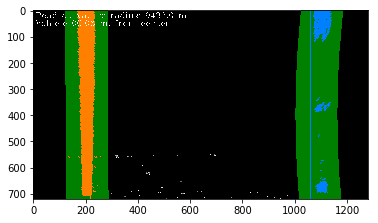

In [6]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
######################## CAMERA_PICKLE ########################
# UPDATE CAMERA PICKLE FOR LATER USAGE
cam_pickle = pickle.load(open("camera_cal/camera_calib_pickle.p", "rb") )
cam_pickle["ym_per_pix"] = ym_per_pix
cam_pickle["xm_per_pix"] = xm_per_pix
pickle.dump(cam_pickle, open("camera_cal/camera_calib_pickle.p", "wb" ))
######################## CAMERA_PICKLE ########################


# Return curvature evaluated at y_eval
def get_curvature(left_fit, right_fit, y_eval):
    left_radius = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_radius + right_radius)/2

# Return vehicle offset from center. > 0 if vehicle is offset to the right of center
def get_offset_from_center(left_fit, right_fit, x_mid, y_eval):
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    x = (left_x + right_x)/2
    return x_mid - x


############### TESTS ###############
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)
binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)

# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)

# Fit a second order polynomial to lane pixels after scaling to real world units (meters)
leftFit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
rightFit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
print('Road curvature radius: ', radius, 'm.')
print('Vehicle offset from center:', offset*xm_per_pix, 'm.')


# Add measurements to the result image
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(fine_search_img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 

txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(fine_search_img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
plt.imshow(fine_search_img)

## 6. Warp the detected lane boundaries back onto the original image.

(1280, 720)


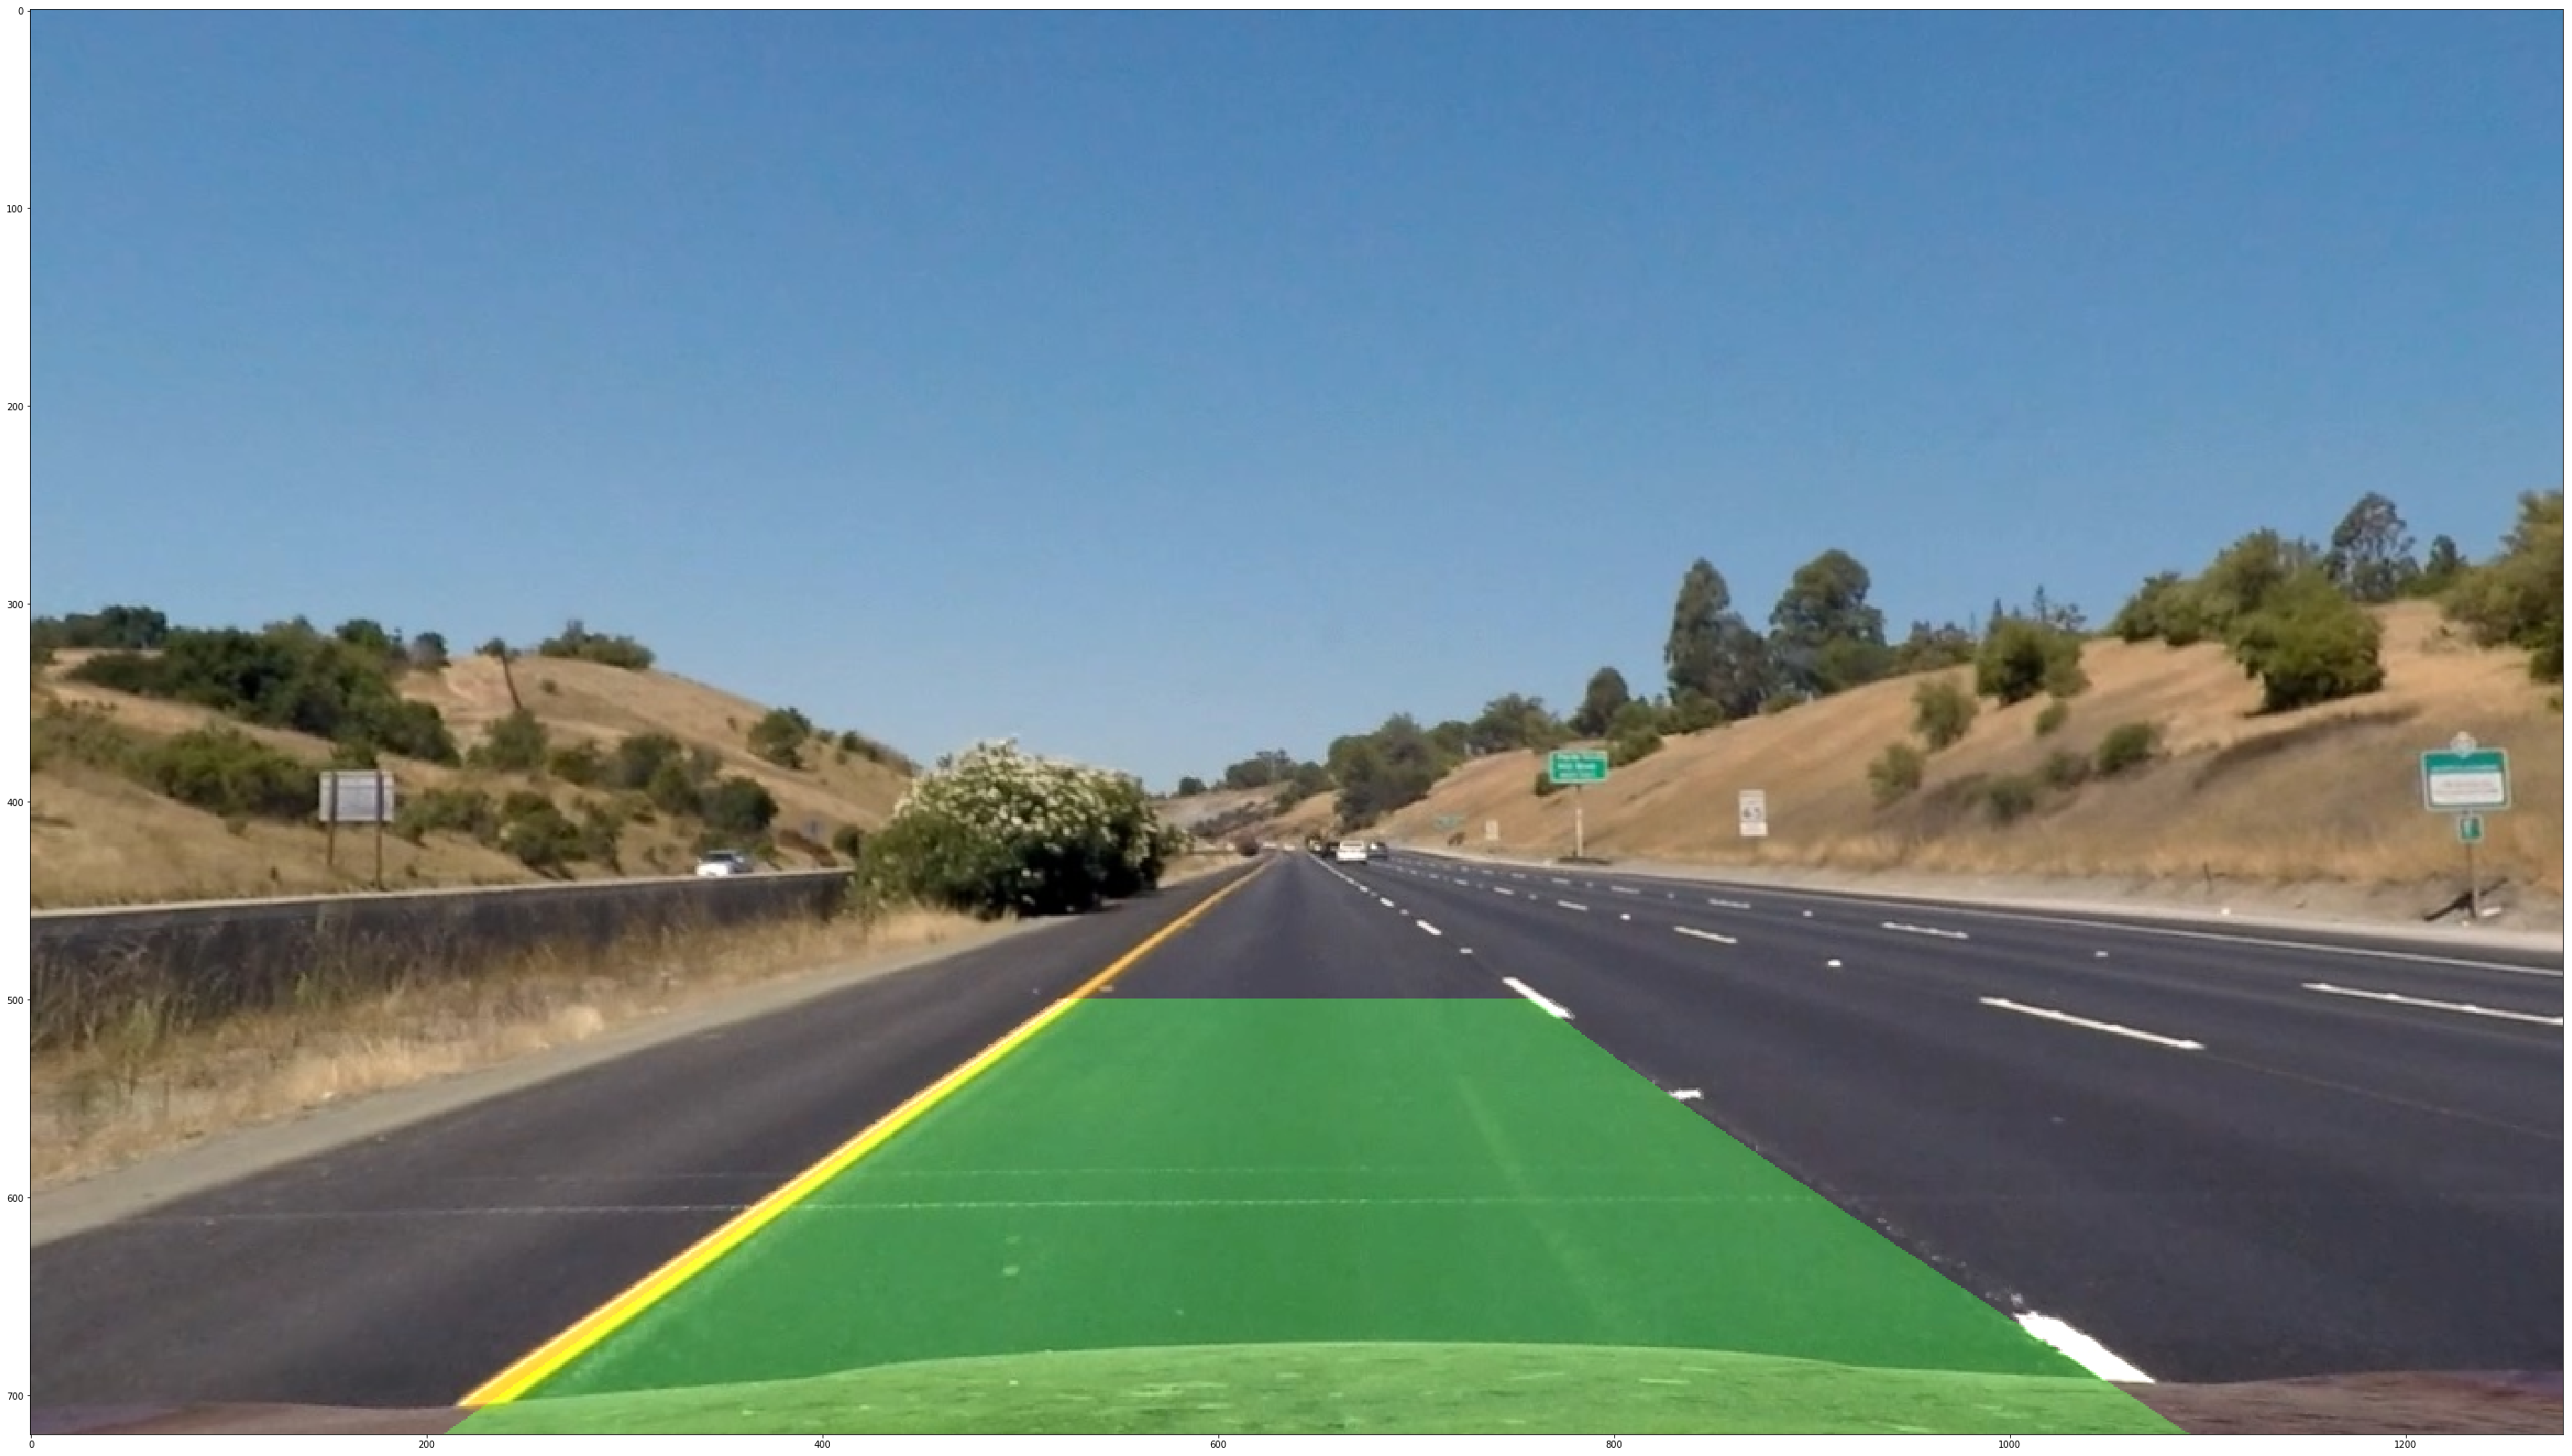

In [7]:
def back_projection(binary_warped_top_view, left_fit, right_fit, inv_perspective_matrix):
    
    # Image
    img_shape = binary_warped_top_view.shape

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_top_view).astype(np.uint8)
    color_warp = np.dstack((binary_warped_top_view, binary_warped_top_view, binary_warped_top_view))#np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (inv_perspective_matrix)
    return cv2.warpPerspective(color_warp, inv_perspective_matrix, (img_shape[1], img_shape[0])) 

    
############### TESTS ###############  
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)

###### Debug save
cv2.imwrite('output_images/back_projected.png', result_img)

# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)
plt.figure(figsize=(50,50))
plt.imshow(img)

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

(1280, 720)


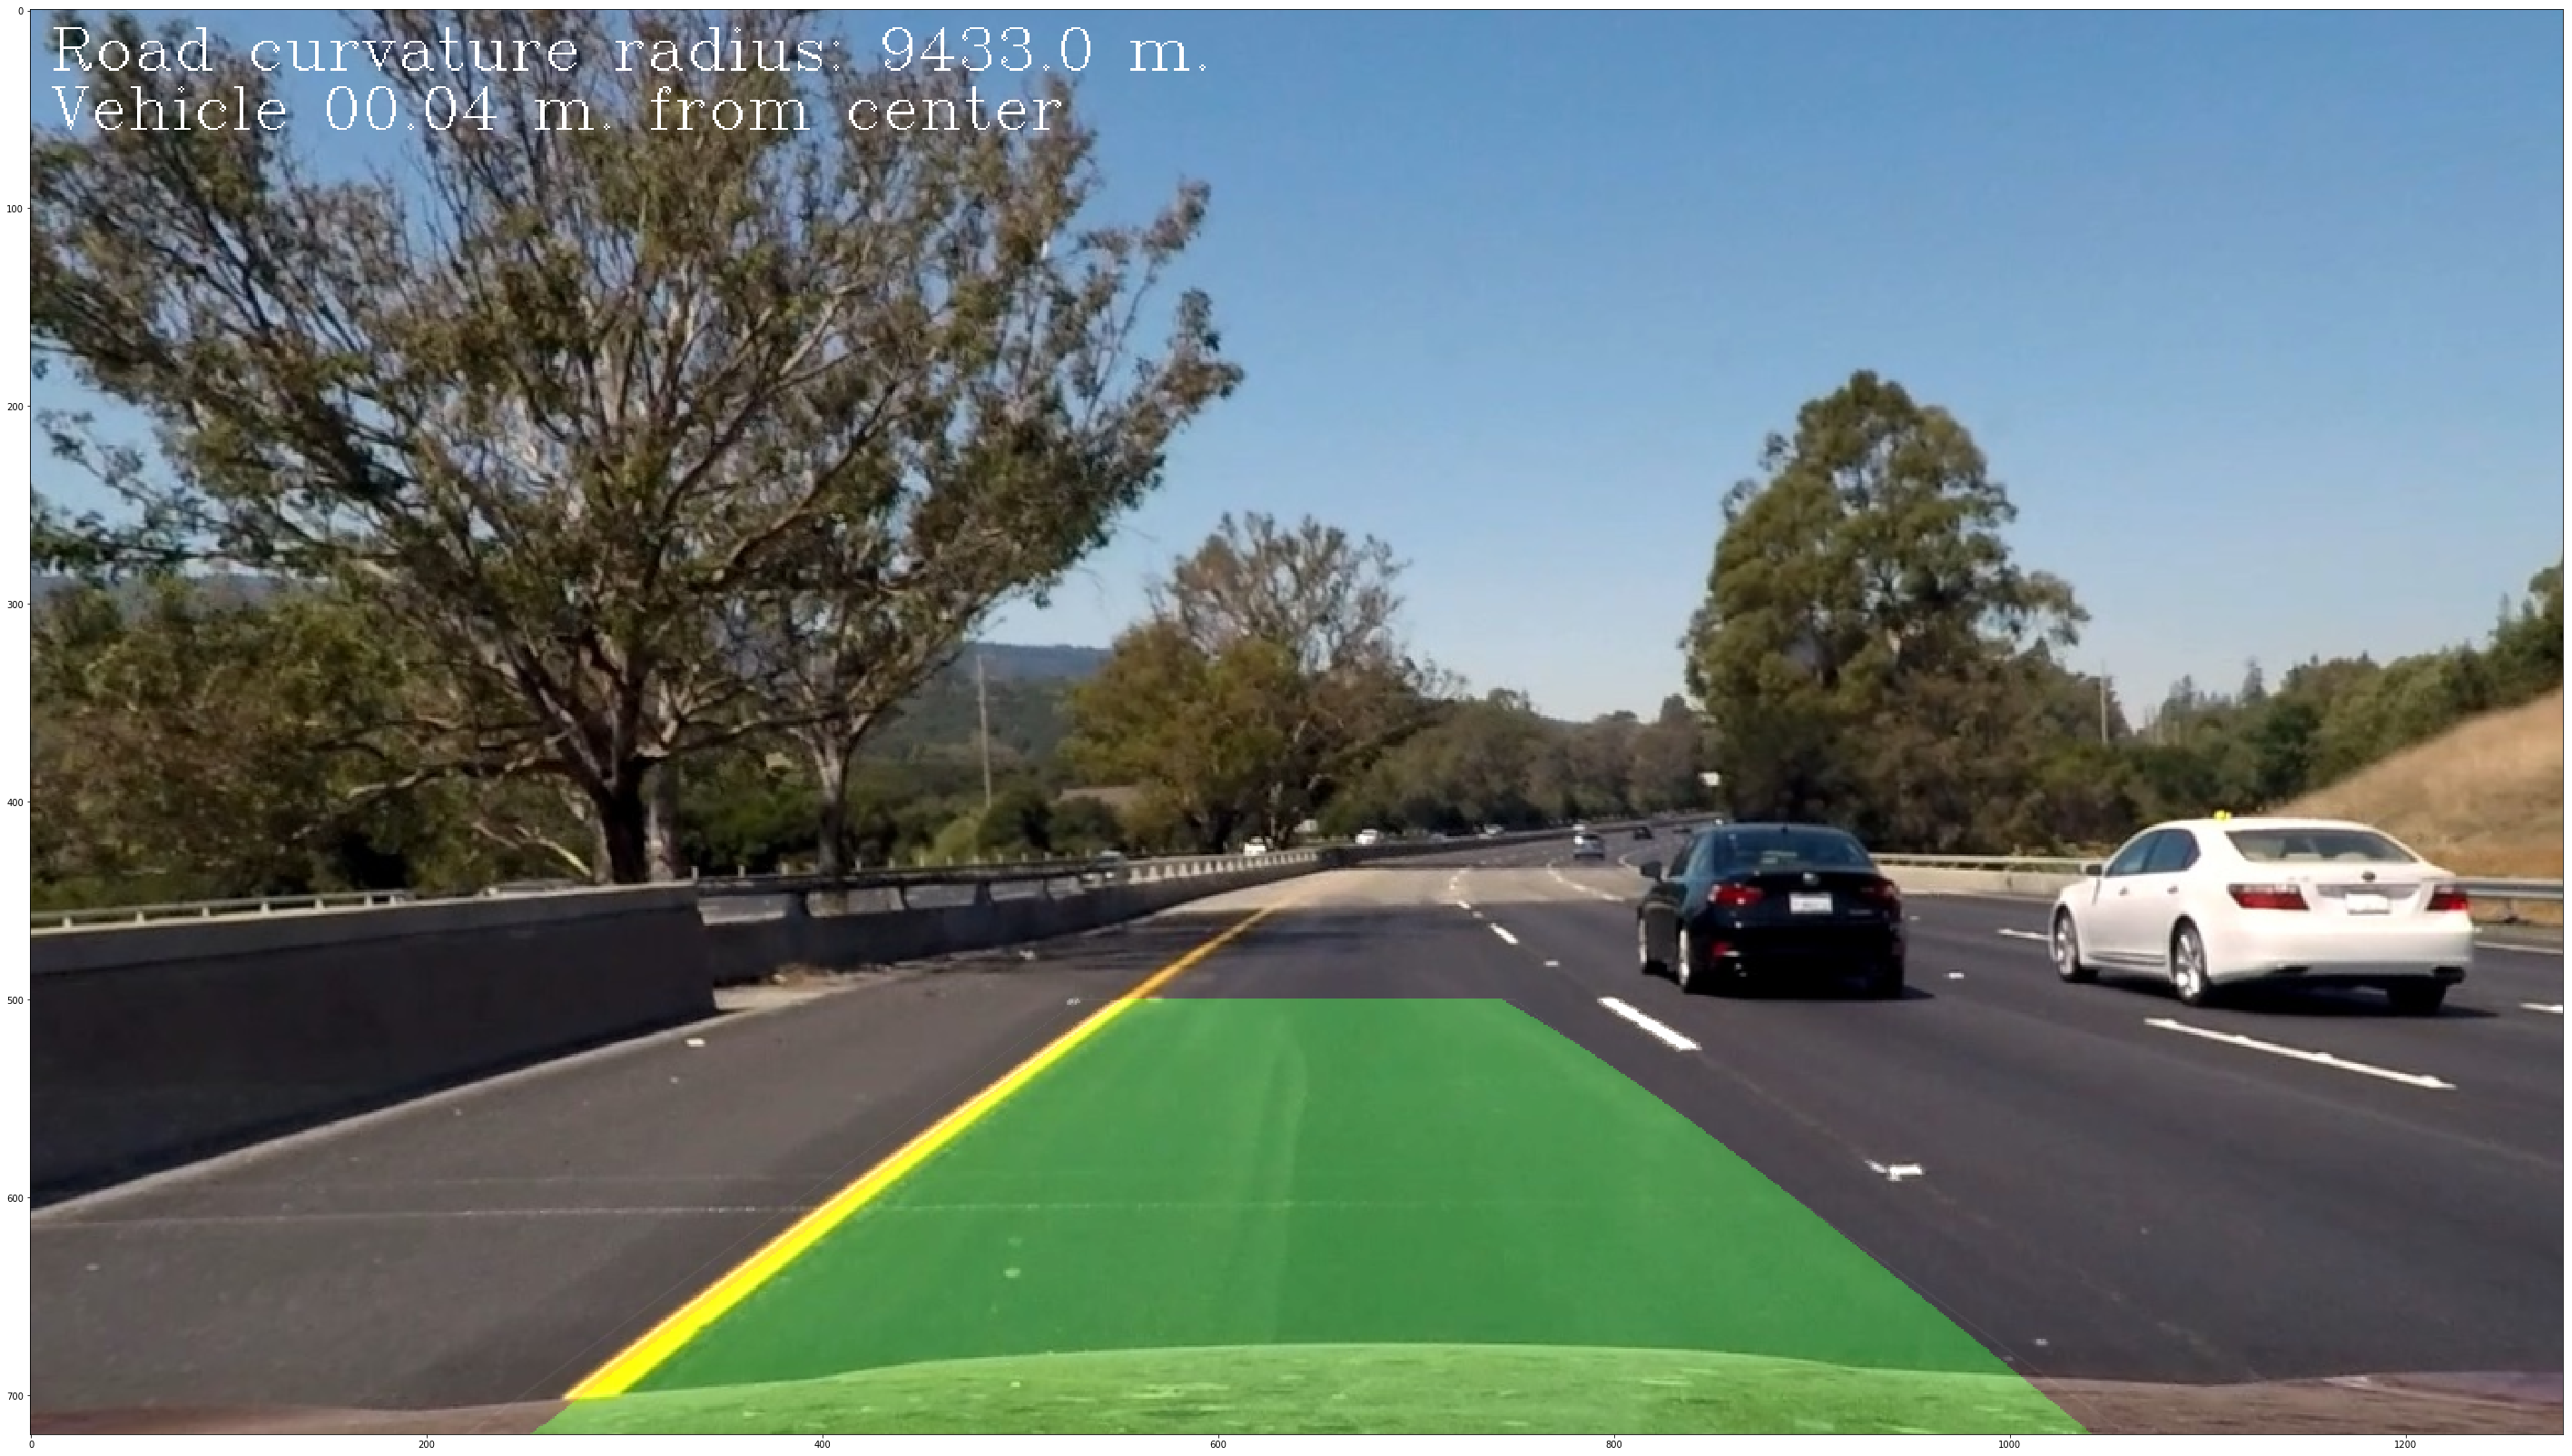

In [8]:
############### TESTS ###############  
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
# Find lane pixels first (coarse)
leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
# Fit a second order polynomial to lane pixels
left_fit  = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Find lane pixels (fine)
found, leftx, lefty, rightx, righty, fine_search_img = find_lane_fine(binary_top_down, left_fit, right_fit)


# Back Projection
result_img = back_projection(binary_top_down, left_fit, right_fit, inv_perspective_matrix)
# Combine the result with the original image
img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)


# Compute radius of curvature of the road and vehicle position relative to lane
radius = get_curvature(leftFit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
offset = get_offset_from_center(left_fit, right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
# Add measurements to the result image
# Curvature
txt = "Road curvature radius: %05.1f m." % (radius)
cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
# Offset from Center
txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
cv2.putText(img, txt, (10,60), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)

plt.figure(figsize=(50,50))
plt.imshow(img)

## 8. Whole Lane detection processing pipeline

In [9]:
class LanesDetector:
    
    def __init__(self):
        self.coarse_search_enabled = True
        self.left_fit = np.array([0, 0, 0])
        self.right_fit = np.array([0, 0, 0])
        self.load_camera_params("camera_cal/camera_calib_pickle.p")

    def load_camera_params(self, params_file_path):
        '''
        Loads gloabl camera parameters athered during cam calibration etc. Search for "CAMERA_PICKLE" tag.
        '''
        cam_pickle = pickle.load(open(params_file_path, "rb") )
        self.cam_mtx = cam_pickle["cam_mtx"]
        self.dist_coeffs = cam_pickle["dist_coeffs"]
        self.inv_perspective_matrix = cam_pickle["inv_perspective_matrix"]
        self.ym_per_pix = cam_pickle["ym_per_pix"] # Meters per pixel in y dimension
        self.xm_per_pix = cam_pickle["xm_per_pix"] # Meters per pixel in x dimension
        #print(cam_pickle)
    
    def process_img(self, image):
        undistorted_img = undistort_image(image, cam_mtx, dist_coeffs)
        binary = apply_threshold(undistorted_img, grad_thresh=(20,100), s_color_thresh=(90,255))
        img_with_roi, transformed_top_down_img, inv_perspective_matrix = top_down_view(binary)

        binary_top_down = cv2.cvtColor(transformed_top_down_img, cv2.COLOR_BGR2GRAY)
        
        if self.coarse_search_enabled:
            # Search for lane pixels lines first (coarse)
            leftx, lefty, rightx, righty, out_img = find_lane_coarse(binary_top_down)
            self.coarse_search_enabled = False
        else:
            # Find lane pixels (fine), Here we know where the lanes are on the image
            found_lane, leftx, lefty, rightx, righty, out_img = find_lane_fine(binary_top_down, left_fit, right_fit)
            if found_lane == False:
                self.coarse_search_enabled == True

        if self.coarse_search_enabled == False:
            # Fit a second order polynomial to lane pixels
            self.left_fit  = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            
            # Apply exponential smoothing
            alpha = 0.7
            self.left_fit  = self.left_fit * alpha + self.left_fit * (1 - alpha)
            self.right_fit = self.right_fit * alpha + self.right_fit * (1 - alpha)

            # Fit a second order polynomial to lane pixels after scaling to real world units (meters)
            left_fit_m  = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

            # Back Projection
            result_img = back_projection(binary_top_down, self.left_fit, self.right_fit, inv_perspective_matrix)
            # Combine the result with the original image
            img = cv2.addWeighted(undistorted_img, 1, result_img, 0.3, 0)


            # Compute radius of curvature of the road and vehicle position relative to lane
            radius = get_curvature(left_fit_m, rightFit_m, binary_top_down.shape[0]*ym_per_pix)
            offset = get_offset_from_center(self.left_fit, self.right_fit, binary_top_down.shape[1]/2, binary_top_down.shape[0])
            # Add measurements to the result image
            # Curvature
            txt = "Road curvature radius: %05.1f m." % (radius)
            cv2.putText(img, txt, (10,30), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1) 
            # Offset from Center
            txt = "Vehicle %05.2f m. from center" % (np.fabs(offset)*xm_per_pix)
            cv2.putText(img, txt, (10,70), cv2.FONT_HERSHEY_COMPLEX, 1, [255,255,255], 1)
        return img
            

lanes_detector = LanesDetector()       

## 9. Search for lanes in Project Video stream 

In [10]:
# Set inputs and outputs
input_video1 = VideoFileClip("project_video.mp4")
output_video_name1 = 'project_video_output.mp4'
input_video2 = VideoFileClip("challenge_video.mp4")
output_video_name2 = 'challenge_video_output.mp4'
input_video3 = VideoFileClip("harder_challenge_video.mp4")
output_video_name3 = 'harder_challenge_video_output.mp4'

lanes_detector = LanesDetector()
process_img  = lanes_detector.process_img


In [11]:
# Process the input video
output_video1 = input_video1.fl_image(process_img)
%time output_video1.write_videofile(output_video_name1, audio=False)


(1280, 720)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)
(1280, 720)


  0%|          | 2/1261 [00:00<01:57, 10.75it/s]

(1280, 720)


  0%|          | 4/1261 [00:00<01:45, 11.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  0%|          | 6/1261 [00:00<01:36, 12.96it/s]

(1280, 720)


  1%|          | 8/1261 [00:00<01:30, 13.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 10/1261 [00:00<01:27, 14.37it/s]

(1280, 720)


  1%|          | 12/1261 [00:00<01:24, 14.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 14/1261 [00:00<01:22, 15.04it/s]

(1280, 720)


  1%|▏         | 16/1261 [00:01<01:20, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|▏         | 18/1261 [00:01<01:20, 15.36it/s]

(1280, 720)


  2%|▏         | 20/1261 [00:01<01:19, 15.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 22/1261 [00:01<01:20, 15.36it/s]

(1280, 720)


  2%|▏         | 24/1261 [00:01<01:18, 15.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 26/1261 [00:01<01:19, 15.57it/s]

(1280, 720)


  2%|▏         | 28/1261 [00:01<01:19, 15.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 30/1261 [00:01<01:17, 15.84it/s]

(1280, 720)


  3%|▎         | 32/1261 [00:02<01:16, 16.08it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 34/1261 [00:02<01:14, 16.38it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 36/1261 [00:02<01:15, 16.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 38/1261 [00:02<01:15, 16.15it/s]

(1280, 720)


  3%|▎         | 40/1261 [00:02<01:15, 16.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 42/1261 [00:02<01:15, 16.11it/s]

(1280, 720)


  3%|▎         | 44/1261 [00:02<01:19, 15.32it/s]

(1280, 720)
(1280, 720)


  4%|▎         | 46/1261 [00:02<01:24, 14.43it/s]

(1280, 720)
(1280, 720)


  4%|▍         | 48/1261 [00:03<01:23, 14.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 50/1261 [00:03<01:19, 15.16it/s]

(1280, 720)


  4%|▍         | 52/1261 [00:03<01:17, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 54/1261 [00:03<01:17, 15.62it/s]

(1280, 720)


  4%|▍         | 56/1261 [00:03<01:16, 15.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 58/1261 [00:03<01:16, 15.70it/s]

(1280, 720)


  5%|▍         | 60/1261 [00:03<01:15, 16.01it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 62/1261 [00:04<01:18, 15.34it/s]

(1280, 720)


  5%|▌         | 64/1261 [00:04<01:16, 15.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 68/1261 [00:04<01:16, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 72/1261 [00:04<01:15, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 76/1261 [00:04<01:14, 15.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▋         | 80/1261 [00:05<01:14, 15.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 84/1261 [00:05<01:14, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 88/1261 [00:05<01:15, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 92/1261 [00:05<01:16, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 96/1261 [00:06<01:12, 16.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 100/1261 [00:06<01:15, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 102/1261 [00:06<01:16, 15.11it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 104/1261 [00:06<01:14, 15.49it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 106/1261 [00:06<01:12, 15.86it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 108/1261 [00:06<01:12, 15.98it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 110/1261 [00:07<01:11, 16.21it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 112/1261 [00:07<01:10, 16.31it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 114/1261 [00:07<01:11, 16.10it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 116/1261 [00:07<01:10, 16.22it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 118/1261 [00:07<01:10, 16.11it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 120/1261 [00:07<01:09, 16.39it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 122/1261 [00:07<01:10, 16.09it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 124/1261 [00:07<01:11, 15.87it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 126/1261 [00:08<01:10, 16.09it/s]

(1280, 720)
(1280, 720)


 10%|█         | 128/1261 [00:08<01:11, 15.91it/s]

(1280, 720)
(1280, 720)


 10%|█         | 130/1261 [00:08<01:10, 16.07it/s]

(1280, 720)
(1280, 720)


 10%|█         | 132/1261 [00:08<01:10, 16.06it/s]

(1280, 720)
(1280, 720)


 11%|█         | 134/1261 [00:08<01:08, 16.35it/s]

(1280, 720)
(1280, 720)


 11%|█         | 136/1261 [00:08<01:09, 16.25it/s]

(1280, 720)
(1280, 720)


 11%|█         | 138/1261 [00:08<01:09, 16.14it/s]

(1280, 720)
(1280, 720)


 11%|█         | 140/1261 [00:08<01:09, 16.18it/s]

(1280, 720)
(1280, 720)


 11%|█▏        | 142/1261 [00:09<01:09, 16.13it/s]

(1280, 720)
(1280, 720)


 11%|█▏        | 144/1261 [00:09<01:09, 16.09it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 146/1261 [00:09<01:09, 16.09it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 148/1261 [00:09<01:08, 16.24it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 150/1261 [00:09<01:08, 16.23it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 152/1261 [00:09<01:10, 15.76it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 154/1261 [00:09<01:09, 15.85it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 156/1261 [00:09<01:08, 16.09it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 158/1261 [00:10<01:08, 16.17it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 160/1261 [00:10<01:07, 16.25it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 162/1261 [00:10<01:06, 16.44it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 164/1261 [00:10<01:07, 16.18it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 166/1261 [00:10<01:07, 16.27it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 168/1261 [00:10<01:07, 16.24it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 170/1261 [00:10<01:06, 16.43it/s]

(1280, 720)
(1280, 720)


 14%|█▎        | 172/1261 [00:10<01:06, 16.27it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 174/1261 [00:11<01:08, 15.81it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 176/1261 [00:11<01:09, 15.68it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 178/1261 [00:11<01:09, 15.66it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 180/1261 [00:11<01:08, 15.68it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 182/1261 [00:11<01:09, 15.63it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 184/1261 [00:11<01:07, 15.91it/s]

(1280, 720)


 15%|█▍        | 186/1261 [00:11<01:10, 15.18it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 188/1261 [00:11<01:10, 15.13it/s]

(1280, 720)


 15%|█▌        | 190/1261 [00:12<01:10, 15.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 194/1261 [00:12<01:08, 15.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 198/1261 [00:12<01:06, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 202/1261 [00:12<01:07, 15.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▋        | 206/1261 [00:13<01:06, 15.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 210/1261 [00:13<01:04, 16.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 214/1261 [00:13<01:05, 16.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 218/1261 [00:13<01:04, 16.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 222/1261 [00:14<01:04, 16.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 226/1261 [00:14<01:03, 16.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 230/1261 [00:14<01:02, 16.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▊        | 234/1261 [00:14<01:01, 16.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 238/1261 [00:15<01:03, 16.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 242/1261 [00:15<01:02, 16.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 246/1261 [00:15<01:02, 16.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 250/1261 [00:15<01:01, 16.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 254/1261 [00:16<01:00, 16.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 258/1261 [00:16<01:00, 16.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 262/1261 [00:16<01:01, 16.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 266/1261 [00:16<01:00, 16.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██▏       | 270/1261 [00:17<01:00, 16.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 274/1261 [00:17<01:02, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 278/1261 [00:17<01:00, 16.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 282/1261 [00:17<00:59, 16.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 286/1261 [00:17<00:59, 16.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 290/1261 [00:18<00:58, 16.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 294/1261 [00:18<00:58, 16.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▎       | 298/1261 [00:18<00:58, 16.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 302/1261 [00:18<00:57, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 306/1261 [00:19<00:57, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 310/1261 [00:19<00:56, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 314/1261 [00:19<00:58, 16.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 318/1261 [00:19<00:58, 16.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 322/1261 [00:20<00:59, 15.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 326/1261 [00:20<00:58, 15.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 330/1261 [00:20<01:00, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▋       | 334/1261 [00:20<00:59, 15.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 338/1261 [00:21<01:00, 15.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 342/1261 [00:21<00:58, 15.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 346/1261 [00:21<00:57, 15.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 350/1261 [00:21<00:57, 15.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 354/1261 [00:22<00:57, 15.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 358/1261 [00:22<00:56, 15.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▊       | 362/1261 [00:22<00:55, 16.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 366/1261 [00:23<00:58, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 368/1261 [00:23<01:01, 14.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 372/1261 [00:23<00:57, 15.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 376/1261 [00:23<00:56, 15.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 380/1261 [00:23<00:54, 16.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 384/1261 [00:24<00:55, 15.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 386/1261 [00:24<00:56, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 390/1261 [00:24<00:55, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 394/1261 [00:24<00:54, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 398/1261 [00:25<00:54, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 402/1261 [00:25<00:54, 15.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 406/1261 [00:25<00:52, 16.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 410/1261 [00:25<00:53, 15.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 412/1261 [00:25<00:54, 15.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 416/1261 [00:26<00:52, 16.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 420/1261 [00:26<00:51, 16.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▎      | 424/1261 [00:26<00:51, 16.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 428/1261 [00:26<00:51, 16.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 434/1261 [00:27<00:49, 16.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 436/1261 [00:27<00:49, 16.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 440/1261 [00:27<00:49, 16.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 446/1261 [00:28<00:49, 16.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 450/1261 [00:28<00:47, 16.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 452/1261 [00:28<00:48, 16.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 456/1261 [00:28<00:48, 16.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▋      | 460/1261 [00:28<00:50, 15.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 464/1261 [00:29<00:48, 16.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 468/1261 [00:29<00:49, 16.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 472/1261 [00:29<00:49, 16.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 476/1261 [00:29<00:48, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 480/1261 [00:30<00:50, 15.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 484/1261 [00:30<00:48, 16.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▊      | 488/1261 [00:30<00:47, 16.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 492/1261 [00:30<00:47, 16.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 498/1261 [00:31<00:46, 16.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 500/1261 [00:31<00:45, 16.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 504/1261 [00:31<00:45, 16.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 508/1261 [00:31<00:45, 16.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 512/1261 [00:32<00:45, 16.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 518/1261 [00:32<00:46, 16.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 520/1261 [00:32<00:46, 15.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 524/1261 [00:32<00:48, 15.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 528/1261 [00:33<00:46, 15.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 534/1261 [00:33<00:44, 16.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 536/1261 [00:33<00:44, 16.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 540/1261 [00:33<00:46, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 544/1261 [00:34<00:46, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 548/1261 [00:34<00:45, 15.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 552/1261 [00:34<00:44, 15.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 556/1261 [00:34<00:44, 15.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 560/1261 [00:35<00:43, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 566/1261 [00:35<00:41, 16.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 568/1261 [00:35<00:43, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 572/1261 [00:35<00:41, 16.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 576/1261 [00:36<00:41, 16.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 580/1261 [00:36<00:41, 16.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▋     | 586/1261 [00:36<00:39, 17.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 590/1261 [00:36<00:39, 17.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 592/1261 [00:37<00:39, 16.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 598/1261 [00:37<00:39, 16.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 600/1261 [00:37<00:40, 16.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 606/1261 [00:37<00:38, 16.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 608/1261 [00:37<00:38, 16.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 614/1261 [00:38<00:39, 16.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 618/1261 [00:38<00:38, 16.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 620/1261 [00:38<00:37, 16.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 626/1261 [00:39<00:38, 16.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 628/1261 [00:39<00:38, 16.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 634/1261 [00:39<00:37, 16.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 636/1261 [00:39<00:39, 15.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 640/1261 [00:39<00:38, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 644/1261 [00:40<00:39, 15.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████▏    | 648/1261 [00:40<00:41, 14.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 652/1261 [00:40<00:41, 14.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 654/1261 [00:40<00:40, 15.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 658/1261 [00:41<00:38, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 662/1261 [00:41<00:38, 15.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 668/1261 [00:41<00:36, 16.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 670/1261 [00:41<00:36, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 674/1261 [00:42<00:36, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 678/1261 [00:42<00:36, 15.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 682/1261 [00:42<00:35, 16.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 686/1261 [00:42<00:36, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 690/1261 [00:43<00:36, 15.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 694/1261 [00:43<00:35, 15.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 698/1261 [00:43<00:36, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 702/1261 [00:43<00:37, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 706/1261 [00:44<00:37, 14.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▋    | 710/1261 [00:44<00:36, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 714/1261 [00:44<00:34, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 718/1261 [00:44<00:34, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 722/1261 [00:45<00:34, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 726/1261 [00:45<00:33, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 730/1261 [00:45<00:33, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 734/1261 [00:45<00:31, 16.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▊    | 738/1261 [00:46<00:32, 16.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 742/1261 [00:46<00:32, 16.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 746/1261 [00:46<00:32, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 750/1261 [00:47<00:32, 15.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 754/1261 [00:47<00:30, 16.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 758/1261 [00:47<00:30, 16.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 762/1261 [00:47<00:30, 16.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 766/1261 [00:47<00:30, 16.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 770/1261 [00:48<00:29, 16.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████▏   | 774/1261 [00:48<00:28, 16.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 778/1261 [00:48<00:28, 16.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 782/1261 [00:48<00:28, 16.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 786/1261 [00:49<00:28, 16.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 790/1261 [00:49<00:28, 16.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 794/1261 [00:49<00:28, 16.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 798/1261 [00:49<00:28, 16.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▎   | 802/1261 [00:50<00:28, 16.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 806/1261 [00:50<00:27, 16.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 810/1261 [00:50<00:27, 16.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 814/1261 [00:50<00:27, 16.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 818/1261 [00:51<00:27, 16.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 822/1261 [00:51<00:26, 16.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 826/1261 [00:51<00:27, 16.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 830/1261 [00:51<00:27, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 834/1261 [00:52<00:27, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 838/1261 [00:52<00:26, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 842/1261 [00:52<00:27, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 846/1261 [00:52<00:27, 14.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 848/1261 [00:53<00:26, 15.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 852/1261 [00:53<00:26, 15.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 856/1261 [00:53<00:26, 15.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 860/1261 [00:53<00:26, 15.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 862/1261 [00:54<00:25, 15.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▊   | 866/1261 [00:54<00:24, 15.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 870/1261 [00:54<00:24, 15.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 874/1261 [00:54<00:24, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 878/1261 [00:55<00:23, 16.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 882/1261 [00:55<00:23, 15.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 886/1261 [00:55<00:22, 16.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 890/1261 [00:55<00:22, 16.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 894/1261 [00:55<00:22, 15.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 898/1261 [00:56<00:22, 16.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 902/1261 [00:56<00:22, 15.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 906/1261 [00:56<00:22, 15.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 910/1261 [00:56<00:21, 16.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 914/1261 [00:57<00:21, 16.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 918/1261 [00:57<00:21, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 922/1261 [00:57<00:20, 16.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 926/1261 [00:57<00:20, 16.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 930/1261 [00:58<00:20, 16.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 934/1261 [00:58<00:20, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 938/1261 [00:58<00:20, 15.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 942/1261 [00:58<00:20, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 946/1261 [00:59<00:19, 15.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 950/1261 [00:59<00:19, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 954/1261 [00:59<00:19, 15.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 958/1261 [01:00<00:19, 15.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▋  | 962/1261 [01:00<00:18, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 966/1261 [01:00<00:18, 15.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 970/1261 [01:00<00:18, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 974/1261 [01:01<00:18, 15.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 978/1261 [01:01<00:18, 15.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 982/1261 [01:01<00:17, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 986/1261 [01:01<00:17, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▊  | 990/1261 [01:02<00:17, 15.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 994/1261 [01:02<00:17, 15.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 998/1261 [01:02<00:17, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 1002/1261 [01:02<00:16, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 1006/1261 [01:03<00:17, 14.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1010/1261 [01:03<00:15, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1014/1261 [01:03<00:15, 16.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1018/1261 [01:03<00:15, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1022/1261 [01:04<00:14, 16.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████▏ | 1026/1261 [01:04<00:14, 16.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1030/1261 [01:04<00:13, 16.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1034/1261 [01:04<00:13, 16.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1038/1261 [01:05<00:13, 16.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1040/1261 [01:05<00:14, 15.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1044/1261 [01:05<00:18, 11.99it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1046/1261 [01:05<00:19, 11.25it/s]

(1280, 720)
(1280, 720)


 83%|████████▎ | 1048/1261 [01:06<00:19, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1052/1261 [01:06<00:17, 12.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 1054/1261 [01:06<00:15, 13.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1058/1261 [01:06<00:13, 14.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1062/1261 [01:06<00:13, 14.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1066/1261 [01:07<00:13, 14.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1070/1261 [01:07<00:13, 14.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1074/1261 [01:07<00:12, 14.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1078/1261 [01:08<00:12, 14.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1082/1261 [01:08<00:11, 15.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1086/1261 [01:08<00:11, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▋ | 1090/1261 [01:08<00:10, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1094/1261 [01:09<00:10, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1098/1261 [01:09<00:10, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1102/1261 [01:09<00:10, 15.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1106/1261 [01:09<00:09, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1110/1261 [01:10<00:09, 15.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1114/1261 [01:10<00:09, 15.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▊ | 1118/1261 [01:10<00:09, 15.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1122/1261 [01:10<00:08, 15.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1126/1261 [01:11<00:08, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1130/1261 [01:11<00:08, 15.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1134/1261 [01:11<00:08, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1138/1261 [01:11<00:07, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1142/1261 [01:12<00:07, 15.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1146/1261 [01:12<00:07, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1150/1261 [01:12<00:06, 16.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1154/1261 [01:12<00:06, 15.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1158/1261 [01:13<00:06, 15.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1162/1261 [01:13<00:06, 15.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1166/1261 [01:13<00:06, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1170/1261 [01:13<00:05, 15.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1174/1261 [01:14<00:05, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1178/1261 [01:14<00:05, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▎| 1182/1261 [01:14<00:04, 16.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1186/1261 [01:14<00:04, 16.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1190/1261 [01:15<00:04, 16.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1194/1261 [01:15<00:04, 16.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1198/1261 [01:15<00:03, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1202/1261 [01:15<00:03, 15.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1206/1261 [01:16<00:03, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1210/1261 [01:16<00:03, 16.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 1214/1261 [01:16<00:03, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 1216/1261 [01:16<00:02, 15.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1220/1261 [01:17<00:02, 15.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1224/1261 [01:17<00:02, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1228/1261 [01:17<00:02, 15.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1232/1261 [01:17<00:01, 15.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1236/1261 [01:18<00:01, 15.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1240/1261 [01:18<00:01, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▊| 1244/1261 [01:18<00:01, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1248/1261 [01:18<00:00, 15.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1252/1261 [01:19<00:00, 15.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1256/1261 [01:19<00:00, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1260/1261 [01:19<00:00, 16.25it/s]


(1280, 720)
(1280, 720)
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 1s, sys: 5.6 s, total: 3min 6s
Wall time: 1min 20s


In [12]:
# SHOW THE VIDEO 1
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name1))

In [13]:
output_video2 = input_video2.fl_image(process_img)
%time output_video2.write_videofile(output_video_name2, audio=False)


(1280, 720)
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

(1280, 720)
(1280, 720)


  0%|          | 2/485 [00:00<00:44, 10.98it/s]

(1280, 720)


  1%|          | 4/485 [00:00<00:40, 11.94it/s]

(1280, 720)
(1280, 720)


  1%|          | 6/485 [00:00<00:38, 12.52it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 8/485 [00:00<00:36, 13.11it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 10/485 [00:00<00:36, 13.13it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 12/485 [00:00<00:34, 13.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  3%|▎         | 14/485 [00:01<00:33, 13.99it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 16/485 [00:01<00:33, 14.19it/s]

(1280, 720)
(1280, 720)


  4%|▎         | 18/485 [00:01<00:32, 14.43it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 22/485 [00:01<00:29, 15.60it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 24/485 [00:01<00:29, 15.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 26/485 [00:01<00:29, 15.75it/s]

(1280, 720)
(1280, 720)


  6%|▌         | 30/485 [00:02<00:28, 16.04it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 32/485 [00:02<00:27, 16.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 36/485 [00:02<00:27, 16.52it/s]

(1280, 720)
(1280, 720)


  8%|▊         | 38/485 [00:02<00:26, 16.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 40/485 [00:02<00:26, 16.76it/s]

(1280, 720)
(1280, 720)


  9%|▊         | 42/485 [00:02<00:27, 16.36it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 44/485 [00:02<00:27, 16.23it/s]

(1280, 720)
(1280, 720)


  9%|▉         | 46/485 [00:02<00:27, 16.04it/s]

(1280, 720)
(1280, 720)


 10%|▉         | 48/485 [00:03<00:27, 16.08it/s]

(1280, 720)
(1280, 720)


 11%|█         | 52/485 [00:03<00:26, 16.61it/s]

(1280, 720)
(1280, 720)


 11%|█         | 54/485 [00:03<00:25, 16.64it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 56/485 [00:03<00:25, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 58/485 [00:03<00:25, 16.97it/s]

(1280, 720)
(1280, 720)


 12%|█▏        | 60/485 [00:03<00:25, 16.52it/s]

(1280, 720)
(1280, 720)


 13%|█▎        | 62/485 [00:03<00:26, 15.95it/s]

(1280, 720)
(1280, 720)


 14%|█▎        | 66/485 [00:04<00:25, 16.57it/s]

(1280, 720)
(1280, 720)


 14%|█▍        | 68/485 [00:04<00:24, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 70/485 [00:04<00:24, 16.90it/s]

(1280, 720)
(1280, 720)


 15%|█▍        | 72/485 [00:04<00:24, 16.77it/s]

(1280, 720)
(1280, 720)


 15%|█▌        | 74/485 [00:04<00:24, 16.73it/s]

(1280, 720)
(1280, 720)


 16%|█▌        | 78/485 [00:04<00:24, 16.93it/s]

(1280, 720)
(1280, 720)


 16%|█▋        | 80/485 [00:05<00:24, 16.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 82/485 [00:05<00:24, 16.39it/s]

(1280, 720)
(1280, 720)


 18%|█▊        | 86/485 [00:05<00:24, 16.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 88/485 [00:05<00:23, 16.75it/s]

(1280, 720)
(1280, 720)


 19%|█▊        | 90/485 [00:05<00:23, 16.61it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 92/485 [00:05<00:23, 16.47it/s]

(1280, 720)
(1280, 720)


 19%|█▉        | 94/485 [00:05<00:23, 16.76it/s]

(1280, 720)
(1280, 720)


 20%|█▉        | 96/485 [00:05<00:23, 16.57it/s]

(1280, 720)
(1280, 720)


 20%|██        | 98/485 [00:06<00:23, 16.51it/s]

(1280, 720)
(1280, 720)


 21%|██        | 100/485 [00:06<00:23, 16.06it/s]

(1280, 720)
(1280, 720)


 21%|██        | 102/485 [00:06<00:23, 16.33it/s]

(1280, 720)
(1280, 720)


 21%|██▏       | 104/485 [00:06<00:23, 16.30it/s]

(1280, 720)
(1280, 720)


 22%|██▏       | 108/485 [00:06<00:22, 16.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 110/485 [00:06<00:22, 16.48it/s]

(1280, 720)
(1280, 720)


 23%|██▎       | 112/485 [00:06<00:22, 16.73it/s]

(1280, 720)
(1280, 720)


 24%|██▎       | 114/485 [00:07<00:22, 16.18it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 116/485 [00:07<00:22, 16.15it/s]

(1280, 720)
(1280, 720)


 24%|██▍       | 118/485 [00:07<00:22, 16.08it/s]

(1280, 720)
(1280, 720)


 25%|██▍       | 120/485 [00:07<00:23, 15.59it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 124/485 [00:07<00:21, 16.51it/s]

(1280, 720)
(1280, 720)


 26%|██▌       | 126/485 [00:07<00:21, 16.45it/s]

(1280, 720)
(1280, 720)


 26%|██▋       | 128/485 [00:07<00:21, 16.92it/s]

(1280, 720)
(1280, 720)


 27%|██▋       | 130/485 [00:08<00:20, 17.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 134/485 [00:08<00:20, 17.18it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 136/485 [00:08<00:20, 16.95it/s]

(1280, 720)
(1280, 720)


 28%|██▊       | 138/485 [00:08<00:19, 17.40it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 140/485 [00:08<00:19, 17.39it/s]

(1280, 720)
(1280, 720)


 29%|██▉       | 142/485 [00:08<00:19, 17.30it/s]

(1280, 720)
(1280, 720)


 30%|██▉       | 144/485 [00:08<00:19, 17.48it/s]

(1280, 720)
(1280, 720)


 30%|███       | 146/485 [00:08<00:19, 17.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 148/485 [00:09<00:19, 17.00it/s]

(1280, 720)
(1280, 720)


 31%|███       | 150/485 [00:09<00:19, 17.06it/s]

(1280, 720)
(1280, 720)


 32%|███▏      | 154/485 [00:09<00:19, 16.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 156/485 [00:09<00:20, 16.20it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 158/485 [00:09<00:20, 16.11it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 160/485 [00:09<00:20, 16.12it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 162/485 [00:09<00:20, 16.03it/s]

(1280, 720)
(1280, 720)


 34%|███▍      | 164/485 [00:10<00:20, 15.39it/s]

(1280, 720)


 34%|███▍      | 166/485 [00:10<00:21, 15.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 168/485 [00:10<00:20, 15.48it/s]

(1280, 720)


 35%|███▌      | 170/485 [00:10<00:20, 15.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 172/485 [00:10<00:19, 15.69it/s]

(1280, 720)


 36%|███▌      | 174/485 [00:10<00:19, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▋      | 176/485 [00:10<00:19, 15.83it/s]

(1280, 720)


 37%|███▋      | 178/485 [00:11<00:19, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 180/485 [00:11<00:19, 15.91it/s]

(1280, 720)


 38%|███▊      | 182/485 [00:11<00:20, 15.06it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 184/485 [00:11<00:19, 15.26it/s]

(1280, 720)
(1280, 720)


 38%|███▊      | 186/485 [00:11<00:19, 15.22it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 188/485 [00:11<00:19, 15.18it/s]

(1280, 720)
(1280, 720)


 39%|███▉      | 190/485 [00:11<00:19, 15.43it/s]

(1280, 720)
(1280, 720)


 40%|███▉      | 192/485 [00:11<00:19, 15.23it/s]

(1280, 720)
(1280, 720)


 40%|████      | 194/485 [00:12<00:19, 14.92it/s]

(1280, 720)
(1280, 720)


 40%|████      | 196/485 [00:12<00:18, 15.58it/s]

(1280, 720)
(1280, 720)


 41%|████      | 198/485 [00:12<00:18, 15.37it/s]

(1280, 720)
(1280, 720)


 41%|████      | 200/485 [00:12<00:18, 15.41it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 202/485 [00:12<00:17, 15.85it/s]

(1280, 720)
(1280, 720)


 42%|████▏     | 204/485 [00:12<00:18, 15.19it/s]

(1280, 720)


 42%|████▏     | 206/485 [00:12<00:18, 15.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 210/485 [00:13<00:17, 15.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 214/485 [00:13<00:16, 16.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 218/485 [00:13<00:16, 16.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 222/485 [00:13<00:15, 16.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 226/485 [00:14<00:15, 16.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 230/485 [00:14<00:15, 16.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 234/485 [00:14<00:14, 16.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 236/485 [00:14<00:14, 16.71it/s]

(1280, 720)


 49%|████▉     | 238/485 [00:14<00:15, 16.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 242/485 [00:15<00:14, 16.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 246/485 [00:15<00:14, 16.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 250/485 [00:15<00:14, 16.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 254/485 [00:15<00:14, 16.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 258/485 [00:15<00:13, 16.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 262/485 [00:16<00:13, 16.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 266/485 [00:16<00:13, 16.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 270/485 [00:16<00:13, 16.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▋    | 274/485 [00:16<00:12, 16.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 278/485 [00:17<00:12, 16.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 282/485 [00:17<00:12, 16.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 286/485 [00:17<00:12, 16.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 290/485 [00:17<00:11, 16.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 294/485 [00:18<00:11, 16.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████▏   | 298/485 [00:18<00:11, 15.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 302/485 [00:18<00:11, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 306/485 [00:18<00:11, 16.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 310/485 [00:19<00:10, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 312/485 [00:19<00:11, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 314/485 [00:19<00:11, 15.35it/s]

(1280, 720)


 65%|██████▌   | 316/485 [00:19<00:10, 15.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 318/485 [00:19<00:10, 15.87it/s]

(1280, 720)


 66%|██████▌   | 320/485 [00:19<00:10, 15.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 322/485 [00:19<00:10, 15.81it/s]

(1280, 720)


 67%|██████▋   | 324/485 [00:20<00:10, 15.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 326/485 [00:20<00:10, 15.68it/s]

(1280, 720)


 68%|██████▊   | 328/485 [00:20<00:09, 15.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 330/485 [00:20<00:09, 16.08it/s]

(1280, 720)


 68%|██████▊   | 332/485 [00:20<00:09, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 334/485 [00:20<00:09, 16.36it/s]

(1280, 720)


 69%|██████▉   | 336/485 [00:20<00:09, 16.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 338/485 [00:20<00:09, 16.05it/s]

(1280, 720)


 70%|███████   | 340/485 [00:21<00:08, 16.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 342/485 [00:21<00:09, 15.62it/s]

(1280, 720)


 71%|███████   | 344/485 [00:21<00:08, 15.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████▏  | 346/485 [00:21<00:08, 16.05it/s]

(1280, 720)


 72%|███████▏  | 348/485 [00:21<00:08, 15.71it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 350/485 [00:21<00:08, 15.11it/s]

(1280, 720)


 73%|███████▎  | 352/485 [00:21<00:08, 15.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 354/485 [00:22<00:08, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 356/485 [00:22<00:08, 15.31it/s]

(1280, 720)


 74%|███████▍  | 358/485 [00:22<00:08, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 360/485 [00:22<00:07, 15.81it/s]

(1280, 720)


 75%|███████▍  | 362/485 [00:22<00:07, 15.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 366/485 [00:22<00:07, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▋  | 370/485 [00:23<00:07, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 374/485 [00:23<00:06, 16.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 378/485 [00:23<00:06, 16.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 382/485 [00:23<00:06, 16.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 386/485 [00:24<00:06, 16.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 390/485 [00:24<00:05, 16.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 396/485 [00:24<00:05, 16.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 398/485 [00:24<00:05, 16.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 404/485 [00:25<00:04, 16.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 406/485 [00:25<00:04, 16.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 412/485 [00:25<00:04, 16.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 416/485 [00:25<00:04, 16.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 418/485 [00:25<00:04, 16.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 424/485 [00:26<00:03, 17.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 426/485 [00:26<00:03, 16.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 432/485 [00:26<00:03, 16.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 434/485 [00:26<00:03, 16.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 438/485 [00:27<00:02, 16.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 444/485 [00:27<00:02, 16.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 446/485 [00:27<00:02, 16.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 450/485 [00:27<00:02, 16.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 456/485 [00:28<00:01, 16.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 458/485 [00:28<00:01, 16.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 462/485 [00:28<00:01, 16.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 468/485 [00:28<00:01, 16.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 472/485 [00:29<00:00, 16.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 476/485 [00:29<00:00, 16.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 480/485 [00:29<00:00, 17.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 482/485 [00:29<00:00, 16.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


100%|██████████| 485/485 [00:29<00:00, 16.19it/s]


(1280, 720)
[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 8s, sys: 2.98 s, total: 1min 11s
Wall time: 30.5 s


In [14]:
# SHOW THE VIDEO 2
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name2))

In [15]:
output_video3 = input_video3.fl_image(process_img)
%time output_video3.write_videofile(output_video_name3, audio=False)


(1280, 720)
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

(1280, 720)


  0%|          | 1/1200 [00:00<02:05,  9.57it/s]

(1280, 720)
(1280, 720)


  0%|          | 3/1200 [00:00<01:58, 10.14it/s]

(1280, 720)


  0%|          | 5/1200 [00:00<01:49, 10.92it/s]

(1280, 720)
(1280, 720)


  1%|          | 7/1200 [00:00<01:41, 11.72it/s]

(1280, 720)
(1280, 720)


  1%|          | 9/1200 [00:00<01:37, 12.27it/s]

(1280, 720)
(1280, 720)


  1%|          | 11/1200 [00:00<01:33, 12.78it/s]

(1280, 720)
(1280, 720)


  1%|          | 13/1200 [00:00<01:29, 13.30it/s]

(1280, 720)
(1280, 720)


  1%|▏         | 15/1200 [00:01<01:26, 13.65it/s]

(1280, 720)
(1280, 720)


  1%|▏         | 17/1200 [00:01<01:25, 13.91it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 19/1200 [00:01<01:23, 14.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  2%|▏         | 21/1200 [00:01<01:21, 14.47it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 23/1200 [00:01<01:20, 14.66it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 25/1200 [00:01<01:17, 15.08it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 27/1200 [00:01<01:15, 15.52it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 29/1200 [00:02<01:14, 15.72it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 31/1200 [00:02<01:16, 15.28it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 33/1200 [00:02<01:16, 15.29it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 35/1200 [00:02<01:14, 15.68it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 37/1200 [00:02<01:16, 15.25it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 39/1200 [00:02<01:15, 15.33it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 41/1200 [00:02<01:15, 15.43it/s]

(1280, 720)
(1280, 720)


  4%|▎         | 43/1200 [00:02<01:17, 14.94it/s]

(1280, 720)


  4%|▍         | 45/1200 [00:03<01:20, 14.40it/s]

(1280, 720)
(1280, 720)


  4%|▍         | 47/1200 [00:03<01:19, 14.58it/s]

(1280, 720)


  4%|▍         | 49/1200 [00:03<01:19, 14.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 51/1200 [00:03<01:22, 13.92it/s]

(1280, 720)
(1280, 720)


  4%|▍         | 53/1200 [00:03<01:21, 14.00it/s]

(1280, 720)


  5%|▍         | 55/1200 [00:03<01:21, 14.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 57/1200 [00:03<01:22, 13.93it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 59/1200 [00:04<01:24, 13.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 61/1200 [00:04<01:28, 12.80it/s]

(1280, 720)


  5%|▌         | 63/1200 [00:04<01:27, 12.94it/s]

(1280, 720)
(1280, 720)


  5%|▌         | 65/1200 [00:04<01:26, 13.07it/s]

(1280, 720)


  6%|▌         | 67/1200 [00:04<01:25, 13.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 69/1200 [00:04<01:26, 13.13it/s]

(1280, 720)
(1280, 720)


  6%|▌         | 71/1200 [00:05<01:23, 13.44it/s]

(1280, 720)


  6%|▌         | 73/1200 [00:05<01:22, 13.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▋         | 75/1200 [00:05<01:22, 13.63it/s]

(1280, 720)
(1280, 720)


  6%|▋         | 77/1200 [00:05<01:23, 13.46it/s]

(1280, 720)


  7%|▋         | 79/1200 [00:05<01:23, 13.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 81/1200 [00:05<01:22, 13.53it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 83/1200 [00:05<01:20, 13.81it/s]

(1280, 720)


  7%|▋         | 85/1200 [00:06<01:18, 14.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 87/1200 [00:06<01:17, 14.35it/s]

(1280, 720)
(1280, 720)


  7%|▋         | 89/1200 [00:06<01:18, 14.18it/s]

(1280, 720)


  8%|▊         | 91/1200 [00:06<01:17, 14.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 95/1200 [00:06<01:16, 14.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 99/1200 [00:07<01:17, 14.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 101/1200 [00:07<01:18, 14.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 105/1200 [00:07<01:15, 14.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 107/1200 [00:07<01:13, 14.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 111/1200 [00:07<01:13, 14.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 115/1200 [00:08<01:11, 15.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 119/1200 [00:08<01:12, 14.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|█         | 123/1200 [00:08<01:12, 14.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 127/1200 [00:08<01:13, 14.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 129/1200 [00:09<01:16, 14.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 133/1200 [00:09<01:18, 13.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 11%|█▏        | 137/1200 [00:09<01:16, 13.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 139/1200 [00:09<01:16, 13.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 143/1200 [00:10<01:15, 14.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 145/1200 [00:10<01:13, 14.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 149/1200 [00:10<01:11, 14.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 151/1200 [00:10<01:11, 14.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 155/1200 [00:10<01:09, 15.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 159/1200 [00:11<01:08, 15.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▎        | 163/1200 [00:11<01:09, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 167/1200 [00:11<01:07, 15.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 171/1200 [00:11<01:05, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 175/1200 [00:12<01:07, 15.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 179/1200 [00:12<01:09, 14.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 181/1200 [00:12<01:09, 14.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 185/1200 [00:12<01:09, 14.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 189/1200 [00:13<01:06, 15.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 193/1200 [00:13<01:07, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 199/1200 [00:13<01:01, 16.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 201/1200 [00:13<01:01, 16.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 205/1200 [00:14<01:00, 16.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 209/1200 [00:14<01:02, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 213/1200 [00:14<01:06, 14.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 215/1200 [00:14<01:12, 13.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 219/1200 [00:15<01:19, 12.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 221/1200 [00:15<01:22, 11.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 225/1200 [00:15<01:24, 11.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 227/1200 [00:15<01:25, 11.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 231/1200 [00:16<01:27, 11.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 233/1200 [00:16<01:25, 11.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 237/1200 [00:16<01:24, 11.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 239/1200 [00:17<01:25, 11.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 243/1200 [00:17<01:25, 11.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 245/1200 [00:17<01:26, 11.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 249/1200 [00:17<01:24, 11.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 251/1200 [00:18<01:24, 11.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██▏       | 255/1200 [00:18<01:23, 11.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 21%|██▏       | 257/1200 [00:18<01:22, 11.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 261/1200 [00:19<01:24, 11.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 263/1200 [00:19<01:26, 10.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 267/1200 [00:19<01:21, 11.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 271/1200 [00:19<01:17, 11.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 273/1200 [00:20<01:17, 11.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 275/1200 [00:20<01:17, 11.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 279/1200 [00:20<01:17, 11.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 281/1200 [00:20<01:21, 11.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 285/1200 [00:21<01:21, 11.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 287/1200 [00:21<01:21, 11.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 291/1200 [00:21<01:21, 11.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 295/1200 [00:21<01:15, 11.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 297/1200 [00:22<01:16, 11.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 301/1200 [00:22<01:12, 12.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 303/1200 [00:22<01:10, 12.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 307/1200 [00:22<01:08, 13.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 309/1200 [00:23<01:07, 13.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 313/1200 [00:23<01:06, 13.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▋       | 315/1200 [00:23<01:08, 12.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 319/1200 [00:23<01:06, 13.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 321/1200 [00:23<01:06, 13.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 325/1200 [00:24<01:04, 13.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 327/1200 [00:24<01:02, 13.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 331/1200 [00:24<00:59, 14.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 335/1200 [00:24<00:55, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 339/1200 [00:25<00:57, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 341/1200 [00:25<00:59, 14.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 345/1200 [00:25<01:01, 13.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 347/1200 [00:25<01:05, 12.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 351/1200 [00:26<01:04, 13.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 353/1200 [00:26<01:04, 13.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 357/1200 [00:26<01:01, 13.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 359/1200 [00:26<00:59, 14.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 363/1200 [00:26<00:58, 14.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 365/1200 [00:27<01:01, 13.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 367/1200 [00:27<01:02, 13.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 371/1200 [00:27<01:05, 12.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███▏      | 375/1200 [00:27<01:02, 13.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 31%|███▏      | 377/1200 [00:28<01:03, 12.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 381/1200 [00:28<01:04, 12.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 383/1200 [00:28<01:02, 13.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 385/1200 [00:28<01:02, 13.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 389/1200 [00:28<01:04, 12.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 391/1200 [00:29<01:04, 12.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 395/1200 [00:29<01:03, 12.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 397/1200 [00:29<01:04, 12.43it/s]

(1280, 720)
(1280, 720)


 33%|███▎      | 399/1200 [00:29<01:09, 11.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▎      | 403/1200 [00:30<01:05, 12.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 405/1200 [00:30<01:03, 12.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 409/1200 [00:30<01:04, 12.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 413/1200 [00:30<01:01, 12.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 415/1200 [00:31<01:03, 12.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 417/1200 [00:31<01:03, 12.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 421/1200 [00:31<01:04, 12.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 425/1200 [00:31<01:01, 12.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 427/1200 [00:32<00:59, 12.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 431/1200 [00:32<01:00, 12.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 433/1200 [00:32<01:00, 12.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▋      | 437/1200 [00:32<00:58, 13.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 439/1200 [00:32<00:57, 13.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 443/1200 [00:33<00:58, 12.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 445/1200 [00:33<00:57, 13.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 449/1200 [00:33<00:54, 13.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 451/1200 [00:33<00:53, 14.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 455/1200 [00:34<00:50, 14.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 457/1200 [00:34<00:50, 14.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 461/1200 [00:34<00:48, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 465/1200 [00:34<00:47, 15.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 469/1200 [00:35<00:47, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 473/1200 [00:35<00:46, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 477/1200 [00:35<00:44, 16.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 481/1200 [00:35<00:42, 16.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 485/1200 [00:35<00:43, 16.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 489/1200 [00:36<00:43, 16.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 493/1200 [00:36<00:42, 16.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████▏     | 497/1200 [00:36<00:43, 16.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 501/1200 [00:36<00:42, 16.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 505/1200 [00:37<00:41, 16.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 509/1200 [00:37<00:39, 17.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 513/1200 [00:37<00:40, 17.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 517/1200 [00:37<00:40, 16.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 521/1200 [00:38<00:40, 16.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 525/1200 [00:38<00:40, 16.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 529/1200 [00:38<00:41, 16.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 533/1200 [00:38<00:40, 16.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 537/1200 [00:39<00:39, 16.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 541/1200 [00:39<00:40, 16.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 545/1200 [00:39<00:41, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 549/1200 [00:39<00:40, 16.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 553/1200 [00:40<00:41, 15.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▋     | 557/1200 [00:40<00:43, 14.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 559/1200 [00:40<00:44, 14.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 563/1200 [00:40<00:44, 14.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 565/1200 [00:40<00:44, 14.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 569/1200 [00:41<00:45, 13.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 571/1200 [00:41<00:47, 13.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 573/1200 [00:41<00:50, 12.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 577/1200 [00:41<00:51, 12.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 579/1200 [00:42<00:52, 11.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 583/1200 [00:42<00:54, 11.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 585/1200 [00:42<00:55, 11.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 589/1200 [00:43<00:56, 10.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 593/1200 [00:43<00:50, 12.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 595/1200 [00:43<00:52, 11.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 597/1200 [00:43<00:53, 11.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 601/1200 [00:44<00:51, 11.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 605/1200 [00:44<00:44, 13.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 609/1200 [00:44<00:45, 13.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 613/1200 [00:44<00:43, 13.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████▏    | 615/1200 [00:45<00:43, 13.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 619/1200 [00:45<00:44, 13.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 621/1200 [00:45<00:43, 13.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 625/1200 [00:45<00:42, 13.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 627/1200 [00:46<00:43, 13.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 631/1200 [00:46<00:42, 13.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 633/1200 [00:46<00:42, 13.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 637/1200 [00:46<00:42, 13.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 639/1200 [00:46<00:41, 13.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 641/1200 [00:47<00:41, 13.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 645/1200 [00:47<00:42, 13.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 647/1200 [00:47<00:44, 12.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 651/1200 [00:47<00:49, 11.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 653/1200 [00:48<00:51, 10.60it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 655/1200 [00:48<00:54, 10.06it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 658/1200 [00:48<00:57,  9.44it/s]

(1280, 720)
(1280, 720)


 55%|█████▍    | 659/1200 [00:48<01:00,  8.98it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 661/1200 [00:49<01:02,  8.67it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 663/1200 [00:49<01:04,  8.30it/s]

(1280, 720)
(1280, 720)


 55%|█████▌    | 665/1200 [00:49<01:05,  8.15it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 667/1200 [00:49<01:07,  7.84it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 669/1200 [00:50<01:09,  7.64it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 671/1200 [00:50<01:11,  7.41it/s]

(1280, 720)
(1280, 720)


 56%|█████▌    | 673/1200 [00:50<01:12,  7.31it/s]

(1280, 720)
(1280, 720)


 56%|█████▋    | 675/1200 [00:50<01:11,  7.31it/s]

(1280, 720)
(1280, 720)


 56%|█████▋    | 677/1200 [00:51<01:11,  7.29it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 680/1200 [00:51<01:04,  8.05it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 682/1200 [00:51<01:01,  8.39it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 684/1200 [00:52<01:00,  8.55it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 685/1200 [00:52<01:01,  8.39it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 688/1200 [00:52<00:57,  8.86it/s]

(1280, 720)
(1280, 720)


 57%|█████▋    | 689/1200 [00:52<00:56,  9.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 693/1200 [00:52<00:54,  9.32it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 695/1200 [00:53<00:53,  9.52it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 697/1200 [00:53<00:53,  9.39it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 698/1200 [00:53<00:52,  9.49it/s]

(1280, 720)
(1280, 720)


 58%|█████▊    | 700/1200 [00:53<00:52,  9.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▊    | 704/1200 [00:54<00:49, 10.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 708/1200 [00:54<00:41, 11.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 710/1200 [00:54<00:38, 12.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 714/1200 [00:54<00:34, 14.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 718/1200 [00:55<00:32, 14.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 724/1200 [00:55<00:29, 16.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 726/1200 [00:55<00:29, 15.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 730/1200 [00:55<00:30, 15.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 734/1200 [00:56<00:32, 14.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████▏   | 736/1200 [00:56<00:33, 13.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 740/1200 [00:56<00:36, 12.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 742/1200 [00:56<00:36, 12.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 746/1200 [00:57<00:35, 12.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▎   | 750/1200 [00:57<00:33, 13.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 752/1200 [00:57<00:33, 13.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 756/1200 [00:57<00:32, 13.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 758/1200 [00:57<00:31, 14.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▎   | 762/1200 [00:58<00:29, 14.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 766/1200 [00:58<00:29, 14.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 770/1200 [00:58<00:28, 15.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 774/1200 [00:58<00:28, 14.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 776/1200 [00:59<00:29, 14.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 780/1200 [00:59<00:28, 14.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 784/1200 [00:59<00:29, 14.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 786/1200 [00:59<00:30, 13.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 788/1200 [00:59<00:30, 13.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 792/1200 [01:00<00:33, 12.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 794/1200 [01:00<00:34, 11.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 798/1200 [01:00<00:36, 10.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 800/1200 [01:01<00:38, 10.49it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 802/1200 [01:01<00:38, 10.26it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 804/1200 [01:01<00:39, 10.08it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 806/1200 [01:01<00:39, 10.03it/s]

(1280, 720)
(1280, 720)


 67%|██████▋   | 808/1200 [01:01<00:39, 10.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 812/1200 [01:02<00:38, 10.08it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 814/1200 [01:02<00:36, 10.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 816/1200 [01:02<00:36, 10.61it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 818/1200 [01:02<00:39,  9.79it/s]

(1280, 720)
(1280, 720)


 68%|██████▊   | 820/1200 [01:03<00:37, 10.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▊   | 824/1200 [01:03<00:35, 10.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 828/1200 [01:03<00:31, 11.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 832/1200 [01:04<00:26, 13.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 836/1200 [01:04<00:25, 14.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 840/1200 [01:04<00:23, 15.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 844/1200 [01:04<00:23, 15.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 846/1200 [01:04<00:24, 14.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 848/1200 [01:05<00:24, 14.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 852/1200 [01:05<00:27, 12.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 854/1200 [01:05<00:28, 12.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 858/1200 [01:06<00:31, 10.85it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 860/1200 [01:06<00:33, 10.23it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 862/1200 [01:06<00:34,  9.69it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 864/1200 [01:06<00:35,  9.36it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 866/1200 [01:06<00:35,  9.43it/s]

(1280, 720)
(1280, 720)


 72%|███████▏  | 868/1200 [01:07<00:35,  9.47it/s]

(1280, 720)
(1280, 720)


 72%|███████▎  | 870/1200 [01:07<00:35,  9.35it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 871/1200 [01:07<00:36,  9.01it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 873/1200 [01:07<00:39,  8.28it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 875/1200 [01:07<00:41,  7.89it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 878/1200 [01:08<00:39,  8.17it/s]

(1280, 720)
(1280, 720)


 73%|███████▎  | 879/1200 [01:08<00:38,  8.43it/s]

(1280, 720)
(1280, 720)


 74%|███████▎  | 882/1200 [01:08<00:34,  9.15it/s]

(1280, 720)
(1280, 720)


 74%|███████▎  | 883/1200 [01:08<00:34,  9.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 887/1200 [01:09<00:31,  9.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 889/1200 [01:09<00:29, 10.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 893/1200 [01:09<00:27, 11.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 897/1200 [01:10<00:25, 11.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 899/1200 [01:10<00:24, 12.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 903/1200 [01:10<00:23, 12.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 905/1200 [01:10<00:24, 12.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 907/1200 [01:10<00:23, 12.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 911/1200 [01:11<00:24, 11.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 913/1200 [01:11<00:25, 11.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▋  | 917/1200 [01:11<00:25, 11.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 919/1200 [01:11<00:24, 11.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 923/1200 [01:12<00:23, 11.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 927/1200 [01:12<00:20, 13.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 931/1200 [01:12<00:18, 14.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 933/1200 [01:12<00:18, 14.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 937/1200 [01:13<00:18, 14.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 941/1200 [01:13<00:17, 14.46it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▊  | 943/1200 [01:13<00:18, 14.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 947/1200 [01:13<00:18, 13.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 949/1200 [01:14<00:18, 13.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 951/1200 [01:14<00:18, 13.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 955/1200 [01:14<00:18, 13.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 959/1200 [01:14<00:17, 13.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 963/1200 [01:15<00:15, 15.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 969/1200 [01:15<00:14, 16.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 971/1200 [01:15<00:14, 16.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████▏ | 975/1200 [01:15<00:13, 16.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 979/1200 [01:16<00:13, 16.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 985/1200 [01:16<00:13, 16.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 989/1200 [01:16<00:12, 16.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 991/1200 [01:16<00:12, 16.53it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 997/1200 [01:17<00:12, 16.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 999/1200 [01:17<00:12, 16.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1005/1200 [01:17<00:11, 17.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1009/1200 [01:17<00:11, 16.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1013/1200 [01:18<00:10, 17.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1015/1200 [01:18<00:11, 16.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1021/1200 [01:18<00:10, 17.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1023/1200 [01:18<00:10, 17.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1027/1200 [01:18<00:10, 16.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1031/1200 [01:19<00:11, 15.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1033/1200 [01:19<00:11, 14.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▋ | 1037/1200 [01:19<00:14, 11.60it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1039/1200 [01:19<00:15, 10.66it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1041/1200 [01:20<00:16,  9.92it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1043/1200 [01:20<00:16,  9.67it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1045/1200 [01:20<00:16,  9.55it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1047/1200 [01:20<00:16,  9.51it/s]

(1280, 720)
(1280, 720)


 87%|████████▋ | 1048/1200 [01:20<00:16,  9.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1052/1200 [01:21<00:15,  9.52it/s]

(1280, 720)
(1280, 720)


 88%|████████▊ | 1053/1200 [01:21<00:15,  9.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1057/1200 [01:21<00:14, 10.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1059/1200 [01:22<00:13, 10.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▊ | 1063/1200 [01:22<00:13, 10.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1065/1200 [01:22<00:12, 10.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1069/1200 [01:22<00:11, 11.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1073/1200 [01:23<00:10, 12.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1075/1200 [01:23<00:09, 12.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1079/1200 [01:23<00:09, 12.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1081/1200 [01:23<00:09, 12.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1085/1200 [01:24<00:08, 13.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1087/1200 [01:24<00:08, 13.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1091/1200 [01:24<00:08, 13.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1093/1200 [01:24<00:08, 13.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████▏| 1097/1200 [01:25<00:07, 12.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1099/1200 [01:25<00:07, 12.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1101/1200 [01:25<00:07, 12.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1105/1200 [01:25<00:07, 12.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1107/1200 [01:25<00:07, 12.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1111/1200 [01:26<00:07, 12.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1115/1200 [01:26<00:06, 12.67it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1117/1200 [01:26<00:06, 12.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1121/1200 [01:26<00:05, 14.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1125/1200 [01:27<00:05, 14.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1129/1200 [01:27<00:04, 15.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1133/1200 [01:27<00:04, 14.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1135/1200 [01:27<00:04, 15.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1139/1200 [01:28<00:03, 15.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1143/1200 [01:28<00:03, 15.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1147/1200 [01:28<00:03, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1151/1200 [01:28<00:03, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 1155/1200 [01:29<00:02, 16.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1159/1200 [01:29<00:02, 15.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1163/1200 [01:29<00:02, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1167/1200 [01:29<00:02, 15.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1169/1200 [01:30<00:02, 15.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1173/1200 [01:30<00:01, 14.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1175/1200 [01:30<00:01, 14.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1177/1200 [01:30<00:01, 13.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1181/1200 [01:30<00:01, 13.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▊| 1183/1200 [01:31<00:01, 12.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1187/1200 [01:31<00:01, 11.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1189/1200 [01:31<00:00, 11.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1193/1200 [01:32<00:00, 11.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1195/1200 [01:32<00:00, 10.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1199/1200 [01:32<00:00, 10.99it/s]


(1280, 720)
(1280, 720)
[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 7s, sys: 5.7 s, total: 3min 13s
Wall time: 1min 33s


In [16]:
# SHOW THE VIDEO 3
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video_name3))